In [3]:
from roboticstoolbox import DHRobot,RevoluteDH,PrismaticDH
import roboticstoolbox as rtb
import numpy as np
from   math import pi
import matplotlib.pyplot as plt
from  spatialmath import *

In [4]:
from Planar3DOF import Planar3DOF
robot=Planar3DOF()
print(robot)
print(robot.links)

ERobot: planar_3dof (by Utadeo), 3 joints (RRR), dynamics, geometry, collision
┌───┬───────────┬───────┬───────────┬────────────────────────────────────────────┐
│id │   link    │ joint │  parent   │                    ETS                     │
├───┼───────────┼───────┼───────────┼────────────────────────────────────────────┤
│ 1 │ world     │       │ BASE      │ {world} = {BASE}                           │
│ 2 │ base_link │       │ world     │ {base_link} = {world}                      │
│ 3 │ link_1    │     0 │ base_link │ {link_1} = {base_link} ⊕ tz(0.05) ⊕ Rz(q0) │
│ 4 │ link_2    │     1 │ link_1    │ {link_2} = {link_1} ⊕ tx(0.5) ⊕ Rz(q1)     │
│ 5 │ gripper   │     2 │ link_2    │ {gripper} = {link_2} ⊕ tx(0.5) ⊕ Rz(q2)    │
│ 6 │ @end      │       │ gripper   │ {end} = {gripper} ⊕ tx(0.18)               │
└───┴───────────┴───────┴───────────┴────────────────────────────────────────────┘

┌─────┬─────┬──────┬───────┐
│name │ q0  │ q1   │ q2    │
├─────┼─────┼──────┼───────┤
│  

In [5]:
print(robot.qs)
robot.plot(robot.qs)

[ 0.          0.         -1.57079633]


Swift backend, t = 0.05, scene:
  planar_3dof

## Fordward and inverse kinematics


In [6]:
print(robot.qs)
T = robot.fkine(robot.qs)
T


[ 0.          0.         -1.57079633]


   0         1         0         1         
  -1         0         0        -0.18      
   0         0         1         0.05      
   0         0         0         1         


In [7]:
sol2=robot.ikine_LM(T,mask=[1,1,1,0,0,0])
print(sol2)
if sol2.success:
    print(robot.fkine(sol2.q))
   
else:
    print("solution not available")

IKsolution(q=array([ 0.03903782, -0.07807886, -1.52752226]), success=True, reason=None, iterations=8, residual=6.538980526491075e-12)
   0.004233  1         0         1         
  -1         0.004233  0        -0.18      
   0         0         1         0.05      
   0         0         0         1         



## Trayectories by hand

Text(0.5, 1.0, 'movimiento deseado en el plano xy del gripper')

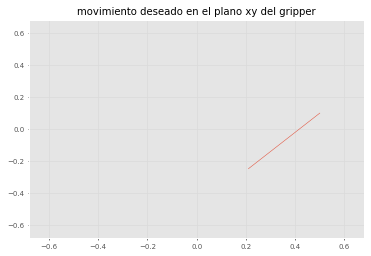

In [8]:
# perfil velocidades del gripper (la de z debe ser zero porque es un robot planar)
pp_d=np.array([-0.1,-0.12,0]) #la velocidad en x,y,z del gripper
#integramos para obtener las posiciones deseadas 
n=30 # numero de pasos
Ts=0.1 # periodo de muestreo
tiempo=np.linspace(0,n*Ts,n) # vector de tiempo


#Cambiar esta trayectoria por su inicial
p_d=np.zeros((n,len(pp_d))) # posición deseada
p_d[0,:]=np.array([0.5,0.1,0.05]) # posición inicial
for i in range(1,n):
    p_d[i,:]=p_d[i-1,:]+Ts*pp_d
    

plt.plot(p_d[:,0],p_d[:,1])
plt.xlim([-0.68,0.68])
plt.ylim([-0.68,0.68])
plt.title('movimiento deseado en el plano xy del gripper')
#p_d

Text(0.5, 1.0, 'angulo deseado del gripper con respecto al tiempo')

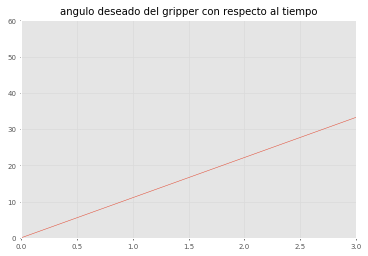

In [9]:
#perfil de orientación del gripper
thetap_d=np.array([0.2]) #velocidad angular del gripper rad/s
#integramos para obtener las posiciones deseadaas 
theta_d=np.zeros((n,len(thetap_d)))
theta_d[0,:]=np.array([0])  #el angulo inicial es 0
for i in range(1,n):
    theta_d[i,:]=theta_d[i-1,:]+Ts*thetap_d
    
#dibujamos
plt.plot(tiempo,theta_d[:,0]*180/pi)
plt.xlim([0,n*Ts])
plt.ylim([0,60])
plt.title('angulo deseado del gripper con respecto al tiempo')

In [12]:
#planear la posición de los motores
q_m=np.zeros((n,len(robot.q))) # posicion del motor en cada instanate de tiempo
qp_m=np.zeros((n,len(robot.q))) # velocidad del motor en cada instante de tiempo
for i in range(0,n): # recorremos los n puntos que queremos que pase el gripper
    # transformar a SE3(una rotacion en z + una translación)
    T=SE3.Rz(theta_d[i,0],unit='rad')
    T=SE3(x=p_d[i,0],y=p_d[i,1],z=p_d[i,2])*T   
    
    #try to add initial guess to increase performance
    sol2=robot.ikine_LM(T,rlimit=1000)
    
    #TODO: what to do if no solution?
    if sol2.success:
        q_m[i,:]=sol2.q
        rank=np.linalg.matrix_rank(robot.jacob0(sol2.q))
        #TODO: if the rank is not three there exist a singular position
        if rank==3:
            qp_m[i,:]=np.matmul(np.linalg.pinv(robot.jacob0(sol2.q)[[0,1,-1],:]),pp_d)
    else:
            print(sol2)

Text(0.5, 1.0, 'velocidad de los motores con respecto al tiempo')

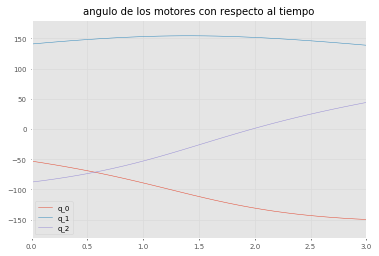

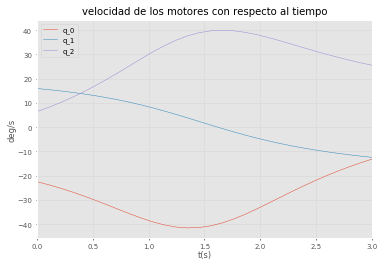

In [13]:
plt.plot(tiempo,q_m*180/pi)
plt.xlim([0,n*Ts])
plt.ylim([-180,180])
plt.legend(['q_0','q_1','q_2'])
plt.title('angulo de los motores con respecto al tiempo')
plt.figure()
plt.plot(tiempo,qp_m*180/pi)
plt.xlim([0,n*Ts])
#plt.ylim([-180,180])
plt.ylabel('deg/s')
plt.xlabel('t(s)')
plt.legend(['q_0','q_1','q_2'])
plt.title('velocidad de los motores con respecto al tiempo')

In [14]:
from roboticstoolbox.backends.swift import Swift
env =  Swift()
env.launch(realtime=True)
env.add(robot)
for i in range(0,10*n):
        robot.q=q_m[i%n,:]
        env.step(Ts)

#env.remove(robot)
#env.close()

## Trajectories with toolbox

### trayectorias directas



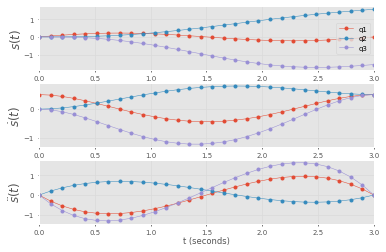

In [27]:
#trayectorias directas
n=30 # numero de pasos
Ts=0.1 # periodo de muestreo
tiempo=np.linspace(0,n*Ts,n) # vector de tiempo
traj = rtb.jtraj(robot.qz, robot.qr, tiempo,qd0=np.array([0.5,0,0]),qd1=np.array([0.5,0.5,0.5]))
traj.plot()

In [23]:
robot.plot(traj.s,block=False)

Swift backend, t = 4.99999999999999, scene:
  planar_3dof

### Trayectoria en coordenadas cartesianas


In [25]:
T_i=SE3(x=p_d[0,0],y=p_d[0,1],z=p_d[0,2])*SE3.Rz(theta_d[0,0],unit='rad')

T_f=SE3(x=p_d[-1,0],y=p_d[-1,1],z=p_d[-1,2])*SE3.Rz(theta_d[-1,0],unit='rad')
Traj=rtb.tools.trajectory.ctraj(T_i, T_f, 20)
Traj

0:
   1         0         0         0.5       
   0         1         0         0.1       
   0         0         1         0.05      
   0         0         0         1         
1:
   1        -0.003615  0         0.4982    
   0.003615  1         0         0.09783   
   0         0         1         0.05      
   0         0         0         1         
2:
   0.9999   -0.01446   0         0.4928    
   0.01446   0.9999    0         0.09132   
   0         0         1         0.05      
   0         0         0         1         
3:
   0.9995   -0.03253   0         0.4837    
   0.03253   0.9995    0         0.08048   
   0         0         1         0.05      
   0         0         0         1         
4:
   0.9983   -0.05781   0         0.4711    
   0.05781   0.9983    0         0.0653    
   0         0         1         0.05      
   0         0         0         1         
5:
   0.9959   -0.09025   0         0.4548    
   0.09025   0.9959    0         0.04578   
   0         0

In [26]:
for t in Traj:
    t.printline()
    #print(t.eul())
    #print(t.angvec())
    print(UnitQuaternion(t.R))

t = 0.5, 0.1, 0.05; rpy/zyx = 0°, 0°, 0°
 1.0000 <<  0.0000,  0.0000,  0.0000 >>
t = 0.498, 0.0978, 0.05; rpy/zyx = 0°, 0°, 0.207°
 1.0000 <<  0.0000,  0.0000,  0.0018 >>
t = 0.493, 0.0913, 0.05; rpy/zyx = 0°, 0°, 0.828°
 1.0000 <<  0.0000,  0.0000,  0.0072 >>
t = 0.484, 0.0805, 0.05; rpy/zyx = 0°, 0°, 1.86°
 0.9999 <<  0.0000,  0.0000,  0.0163 >>
t = 0.471, 0.0653, 0.05; rpy/zyx = 0°, 0°, 3.31°
 0.9996 <<  0.0000,  0.0000,  0.0289 >>
t = 0.455, 0.0458, 0.05; rpy/zyx = 0°, 0°, 5.18°
 0.9990 <<  0.0000,  0.0000,  0.0452 >>
t = 0.435, 0.0219, 0.05; rpy/zyx = 0°, 0°, 7.46°
 0.9979 <<  0.0000,  0.0000,  0.0650 >>
t = 0.412, -0.00532, 0.05; rpy/zyx = 0°, 0°, 10.1°
 0.9962 <<  0.0000,  0.0000,  0.0877 >>
t = 0.389, -0.0328, 0.05; rpy/zyx = 0°, 0°, 12.7°
 0.9939 <<  0.0000,  0.0000,  0.1104 >>
t = 0.366, -0.0603, 0.05; rpy/zyx = 0°, 0°, 15.3°
 0.9911 <<  0.0000,  0.0000,  0.1332 >>
t = 0.344, -0.0877, 0.05; rpy/zyx = 0°, 0°, 17.9°
 0.9878 <<  0.0000,  0.0000,  0.1558 >>
t = 0.321, -0.115, 0.0